# **Homework 5: Basic Block Recursivity**

## **ECON8582: Macro-Labour**

#### *Conor Bayliss*

In [1]:
using LinearAlgebra, QuantEcon, Random, Makie, CairoMakie, Distributions

#### **Calibration**

In [39]:
pars = (;β = 0.996, # discount factor
        ρ = 0.98, # autocorrelation of productivity process
        σe = 0.01, # standard deviation of productivity process
        nz = 15, # number of points in the productivity grid
        γ = 0.6, # coefficient of job finding rate
        κ = 1.89, # vacancy posting cost
        δ = 0.012, # separation rate
        σ = 0, # CRRA parameter
        α = 1, # search cost parameter
        χ = 2, # search cost exponent
        a = 1/3, # λ(s) = s^a job posting opportunities
        w_lb = .1, # lower bound of wage grid
        w_ub = 1, # upper bound of wage grid
        Δw = 0.025, # wage grid step
        b = 0.54, # benefit parameter
        b_end = 0.1, # prob of moving to lowest benefits
        s_lb = 0.2, # lower bound of search cost grid
        s_ub = 0.4, # upper bound of search cost grid
        Δs = 0.02, # search cost grid step
        toler = 1e-6, # tolerance for convergence
        maxiter = 100000, # maximum number of iterations
        Np = 40000, # number of agents
        T = 200, # number of periods
        Tb = 100) # burn-in periods

(β = 0.996, ρ = 0.98, σe = 0.01, nz = 15, γ = 0.6, κ = 1.89, δ = 0.012, σ = 0, α = 1, χ = 2, a = 0.3333333333333333, w_lb = 0.1, w_ub = 1, Δw = 0.025, b = 0.54, b_end = 0.1, s_lb = 0.2, s_ub = 0.4, Δs = 0.02, toler = 1.0e-6, maxiter = 100000, Np = 40000, T = 200, Tb = 100)

##### **Income process**

In [3]:
function income_process(p)
    (;ρ, σe, nz) = p
    mc = rouwenhorst(nz, ρ, σe)
    z_grid = exp.(mc.state_values)
    Π = mc.p
    return z_grid, Π 
end

test_z_grid, test_Π = income_process(pars)

([0.8285936952614785, 0.8511519660876842, 0.8743243805956225, 0.8981276587043299, 0.9225789755287533, 0.9476959737723538, 0.9734967764570943, 1.0, 1.027224767645724, 1.0551907232648117, 1.0839180455276196, 1.1134274624641165, 1.14374026642007, 1.174878329420415, 1.2068641189508822], [0.8687458127689781 0.1228529432198556 … 1.386000000000016e-25 1.0000000000000126e-28; 0.008775210229989686 0.8698981131022091 … 1.2741400000000137e-23 9.900000000000117e-27; … ; 9.900000000000117e-27 1.2741400000000137e-23 … 0.8698981131022091 0.008775210229989686; 1.0000000000000126e-28 1.386000000000016e-25 … 0.1228529432198556 0.8687458127689781])

##### **Wage grid**

In [4]:
function wage_grid(pars)
    (;w_lb, w_ub, Δw) = pars
    w_grid = range(w_lb, w_ub, step = Δw)
    return w_grid
end

test_w_grid = wage_grid(pars)

0.1:0.025:1.0

##### **Search grid**

In [5]:
function search_cost_grid(pars)
    (;s_lb, s_ub, Δs) = pars
    s_grid = range(s_lb, s_ub, step = Δs)
    return s_grid
end

test_s_grid = search_cost_grid(pars)

0.2:0.02:0.4

##### **Job finding rate**

In [6]:
function job_finding_rate(θ, pars)
    (;γ) = pars
    p = θ*(1. + θ^γ)^(-1/γ)
    return p
end

job_finding_rate (generic function with 1 method)

##### **Job posting opportunities**

In [7]:
function job_opp(s, pars)
    (;a) = pars
    job_opp = s^a
    return job_opp
end

test_job_opp = job_opp(test_s_grid[1],pars)

0.5848035476425733

##### **Benefits grid**

In [8]:
function benefits_grid(pars)
    (;b) = pars
    temp_w_grid = wage_grid(pars)
    benefits = b .* temp_w_grid
    return benefits
end

test_benefits = benefits_grid(pars)

0.054000000000000006:0.013500000000000002:0.54

##### **Utility**

In [9]:
function utility(c,pars)
    (;σ) = pars
    
    if σ == 1
        u = log
    else
        u = x -> (x^(1-σ) - 1)/(1-σ)
    end

    return u(c)
end

test_c = utility(2,pars)

1.0

##### **Job destruction**

In [10]:
function job_dest(z,w,pars)
    (;δ) = pars
    if z >= w
        return δ
    else
        return 1
    end
end

test_job_dest = job_dest(test_z_grid[5],test_w_grid[34],pars)

1

##### **Search costs**

In [11]:
function search_costs(s,pars)
    (;α, χ) = pars
    return α * (s^χ)
end

test_search_costs = search_costs(test_s_grid[1],pars)

0.04000000000000001

##### **Initial guess for $\mathbf{J}$**

In [12]:
function initial_J(pars)
    (;nz,w_ub,w_lb,Δw) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    J = zeros(nw,nz)
    return J
end

test_J = initial_J(pars)

37×15 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0 

#### **Value function iteration on $\mathbf{J}$**

In [13]:
function iterate_J(pars)
    (;nz, w_ub, w_lb, Δw, a, b, γ, κ, δ, α, χ, β, toler, maxiter) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    J_init = initial_J(pars)
    J_new = copy(J_init)
    error = 1
    iter = 1
    z_grid, Π = income_process(pars)
    w_grid = wage_grid(pars)
    EV = zeros(nw,nz)
    while iter <= maxiter
        J_new = copy(J_init)
        for i in 1:nw
            for j in 1:nz
                EV[i,j] = 0
                for jp in 1:nz
                    EV[i,j] += J_init[i,jp] * Π[j,jp]
                end
            end
            J_init[i,:] = z_grid .- w_grid[i] .+ (β .* (1 .- job_dest.(z_grid,w_grid[i],Ref(pars)))) .* EV[i,:]
        end
        error = maximum(abs.(J_new - J_init))
        J_new = copy(J_init)
        if error < toler
            println("--------------------")
            println("Converged in $iter iterations")
            println("Error: $error")
            println("--------------------")
            break
        end
        if iter == maxiter
            println("Maximum number of iterations reached")
        end
        if iter == 1
            println("--------------------")
            println("Iteration: $iter")
            println("Error: $error")
            println("--------------------")
        end
        if iter % 100 == 0
            println("--------------------")
            println("Iteration: $iter")
            println("Error: $error")
            println("--------------------")
        end
        iter += 1
    end
    return J_new
end

 @time J_out = iterate_J(pars)

--------------------
Iteration: 1
Error: 1.106864118950882
--------------------
--------------------
Iteration: 100
Error: 0.18867370091780344
--------------------
--------------------
Iteration: 200
Error: 0.03687394205703498
--------------------
--------------------
Iteration: 300
Error: 0.007360990328706407
--------------------
--------------------
Iteration: 400
Error: 0.0014735920943351744
--------------------
--------------------
Iteration: 500
Error: 0.0002951078404294094
--------------------
--------------------
Iteration: 600
Error: 5.9102486900997064e-5
--------------------
--------------------
Iteration: 700
Error: 1.1836781190766033e-5
--------------------
--------------------
Iteration: 800
Error: 2.3706195619865866e-6
--------------------
--------------------
Converged in 854 iterations
Error: 9.948122894343214e-7
--------------------
  0.999681 seconds (900.71 k allocations: 87.279 MiB, 3.56% gc time, 94.25% compilation time)


37×15 Matrix{Float64}:
 51.5029     52.1771    52.8629       …  60.4167   61.2475   62.093
 49.9357     50.6099    51.2957          58.8495   59.6803   60.5258
 48.3685     49.0427    49.7285          57.2823   58.1131   58.9586
 46.8013     47.4755    48.1613          55.7151   56.5459   57.3914
 45.2341     45.9083    46.5941          54.1479   54.9787   55.8242
 43.6669     44.3411    45.0269       …  52.5807   53.4115   54.257
 42.0997     42.7739    43.4597          51.0135   51.8443   52.6898
 40.5325     41.2067    41.8925          49.4463   50.2771   51.1226
 38.9653     39.6395    40.3253          47.8791   48.7099   49.5554
 37.3981     38.0723    38.7581          46.3119   47.1427   47.9882
  ⋮                                   ⋱                      
  7.62132     8.29549    8.98132         16.5351   17.3659   18.2114
  6.05412     6.72829    7.41412         14.9679   15.7987   16.6442
 -0.0214063   4.85121    5.7971       …  13.4004   14.2312   15.0768
 -0.0464063  -0.0238

#### **Solve for $\theta$, setting $\theta = 0$ in cases where $\mathbf{J}<0$.** 

To do so, first notice that we have
$$
\theta(w;\psi) = \frac{v(w;\psi)}{u(w;\psi)}, \quad q(\theta(w;\psi)) = \frac{M(w;\psi)}{v(w;\psi)}, \quad p(\theta(w;\psi)) = \frac{M(w;\psi)}{u(w;\psi)}
$$
and rearranging the last two conditions gives
$$
v(w;\psi) = \frac{M(w;\psi)}{q(\theta(w;\psi))}, \quad u(w;\psi) = \frac{M(w;\psi)}{p(\theta(w;\psi))}
$$
and, plugging into his first condition, we obtain
$$
p(\theta(w;\psi)) = \theta(w;\psi) q(\theta(w;\psi)).
$$
In the problem, we are told to assume that 
$$
p(\theta(w;\psi)) = \theta(w;\psi) (1+\theta(w;\psi)^\gamma)^{-\frac{1}{\gamma}}
$$
and therefore we have
$$
q(\theta(w;\psi)) = (1+\theta(w;\psi)^\gamma)^{-\frac{1}{\gamma}}.
$$
Since we want to find the $\theta$'s themselves, we then use the free-entry condition
$$
\kappa = q(\theta(w;\psi))\mathbf{J}(w;\psi)
$$
$$
\implies \kappa = (1+\theta(w;\psi)^\gamma)^{-\frac{1}{\gamma}} \mathbf{J}(w;\psi)
$$
by our functional form for $q$. Then, rearranging, we find
$$
\theta(w;\psi) = \left[\left(\frac{\mathbf{J}(w;\psi)}{\kappa}\right)^\gamma  - 1\right]^{\frac{1}{\gamma}}.
$$

#### **Thetas**

In [14]:
function thetas(J,pars)
    (;γ, κ, nz, w_lb,w_ub,Δw) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    Θ = zeros(nw,nz)
    for i in 1:nw
        for j in 1:nz
            if J[i,j] / κ >= 1.0
                Θ[i,j] = ((J[i,j] / κ)^γ - 1.)^(1/γ)
            else
                Θ[i,j] = 0
            end
        end
    end
    return Θ
end

test_thetas = thetas(J_out,pars)

37×15 Matrix{Float64}:
 21.29     21.6133    21.9425    …  25.5845    25.9867    26.3965
 20.5395   20.8621    21.1907       24.8266    25.2282    25.6373
 19.7905   20.1125    20.4404       24.0698    24.4708    24.8793
 19.0432   19.3644    19.6916       23.3142    23.7145    24.1224
 18.2975   18.6181    18.9445       22.5599    22.9596    23.3667
 17.5537   17.8734    18.1991    …  21.807     22.2059    22.6124
 16.8117   17.1307    17.4555       21.0555    21.4537    21.8593
 16.0718   16.3899    16.7138       20.3054    20.7028    21.1077
 15.3341   15.6512    15.9742       19.557     19.9535    20.3576
 14.5987   14.9147    15.2367       18.8101    19.2058    19.609
  ⋮                              ⋱                        
  1.56551   1.81296    2.07055       5.1523     5.50924    5.87508
  1.01795   1.24812    1.49074       4.48638    4.83808    5.19901
  0.0       0.633606   0.932713  …   3.83162    4.1771     4.53227
  0.0       0.0        0.0           3.18025    3.51925   

#### **Probs**

In [15]:
function θ_probs(Θ,pars)
    (;γ, nz, w_lb,w_ub,Δw) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    P = zeros(nw,nz)
    P = Θ .* (1 .+ Θ.^γ).^(-1/γ)
    return P
end

test_probs = θ_probs(test_thetas,pars) 

37×15 Matrix{Float64}:
 0.781278  0.782894  0.784506  0.786112  …  0.800353  0.80191   0.803462
 0.777392  0.779086  0.780775  0.782457     0.797325  0.798945  0.80056
 0.773314  0.775093  0.776864  0.778628     0.794169  0.795858  0.797539
 0.769029  0.770899  0.77276   0.774612     0.790877  0.79264   0.794393
 0.764518  0.766487  0.768446  0.770394     0.78744   0.789281  0.791111
 0.759761  0.761839  0.763904  0.765955  …  0.783846  0.785772  0.787684
 0.754736  0.756932  0.759113  0.761278     0.780084  0.7821    0.784102
 0.749417  0.751743  0.75405   0.756339     0.77614   0.778254  0.780352
 0.743775  0.746244  0.748691  0.751115     0.771999  0.77422   0.776421
 0.737777  0.740403  0.743003  0.745578     0.767645  0.769981  0.772294
 ⋮                                       ⋱                      
 0.388229  0.413056  0.43572   0.456513     0.588918  0.599594  0.609723
 0.317787  0.3506    0.380018  0.406562     0.566495  0.578781  0.590364
 0.0       0.246849  0.304088  0.3414

#### **Initial guess for $\mathbf{W}$**

In [16]:
function initial_W(pars)
    (;nz,w_ub,w_lb,Δw) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    W = ones(nw,nz)
    return W
end

test_W = initial_W(pars)

37×15 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮                        ⋮                   
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0 

#### **Initial guess for $\mathbf{U}$**

In [17]:
function initial_U(pars)
    (;nz,w_ub,w_lb,Δw) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    U = ones(nw,nz)
    return U
end

test_U = initial_U(pars)

37×15 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮                        ⋮                   
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0 

#### **Value function iteration to find $\mathbf{W}$ and $\mathbf{U}$**

In [18]:
function iterate_W_U(pars)
    (;nz, w_ub, w_lb, Δw, s_lb, s_ub, Δs, a, b, γ, κ, δ, α, χ, β, toler, maxiter) = pars
    nw = (w_ub - w_lb)/Δw + 1
    nw = round(Int,nw)
    ns = (s_ub - s_lb)/Δs + 1
    ns = round(Int,ns)
    W_init = initial_W(pars)
    U_init = initial_U(pars)
    W_new = copy(W_init)
    U_new = copy(U_init)
    search_policy = zeros(nw,nz)
    posting_decision = zeros(nw, nz)
    w_hat = zeros(nw,nz)
    EW = zeros(nw,nz)
    EU = zeros(nw,nz,ns)
    final_util = zeros(ns)
    z_grid, Π = income_process(pars)
    w_grid = wage_grid(pars)
    b_grid = benefits_grid(pars)
    s_grid = search_cost_grid(pars)
    Θ = thetas(J_out,pars)
    P = θ_probs(Θ,pars)
    error = toler+1
    iter = 1
    while iter <= maxiter
        ### Value of employment ###
        for i in 1:nw
            for j in 1:nz
                EW[i,j] = 0
                for jp in 1:nz
                    EW[i,j] += Π[j,jp] * (1-job_dest(z_grid[jp],w_grid[i],pars)) * W_init[i,jp] + Π[j,jp] * job_dest(z_grid[jp],w_grid[i],pars) * U_init[i,jp]
                end
                W_new[i,j] = utility(w_grid[i],pars) + β * EW[i,j]
            end
        end 
        ### Posting decision ### 
        for i in 1:nw
            for j in 1:nz
                max_posting_value = zeros(nw)
                for ip in 1:nw
                    max_posting_value[ip] = P[ip,j] * W_new[ip,j] + (1 - P[ip,j]) * (0.9 * U_new[ip,j] + 0.1 * U_new[1,j])
                end
                posting_decision[i,j], index = findmax(max_posting_value)
                w_hat[i,j] = w_grid[index]
            end
        end
        ### Value of unemployment ###
        for i in 1:nw
            for j in 1:nz
                for s in 1:ns
                    EU[i,j,s] = 0
                    util = utility(b_grid[i],pars) - search_costs(s_grid[s],pars) 
                    λ = job_opp(s_grid[s],pars)
                    for jp in 1:nz
                        EU[i,j,s] += Π[j,jp] * λ * posting_decision[i,j] + Π[j,jp] * (1 - λ) * (0.1 * U_new[1,jp] .+ 0.9 * U_new[i,jp])
                    end
                    final_util[s] = util + β * EU[i,j,s]
                end
                max_value, max_index = findmax(final_util)
                U_new[i,j] = max_value
                search_policy[i,j] = s_grid[max_index]
            end
        end
        ### Check for convergence ###                            
        errorW = maximum(abs.(W_new - W_init))
        errorU = maximum(abs.(U_new - U_init))
        error = max(errorW,errorU)
        if error < toler
            println("--------------------")
            println("Converged in $iter iterations")
            println("Error: $error")
            println("--------------------")
            break
        end
        if iter == maxiter
            println("Maximum number of iterations reached")
        end
        if iter == 1
            println("--------------------")
            println("Iteration: $iter")
            println("Error: $error")
        end
        if iter % 100 == 0
            println("--------------------")
            println("Iteration: $iter")
            println("Error: $error")
        end
        ### Update values ###
        W_init = copy(W_new)
        U_init = copy(U_new)
        iter += 1
    end

    return W_init,U_init,search_policy, w_hat
end

@time W_out, U_out, s_pol, wage_indexes = iterate_W_U(pars)

--------------------
Iteration: 1
Error: 1.0726591995961223
--------------------
Iteration: 100
Error: 0.2683878586788069
--------------------
Iteration: 200
Error: 0.09837821246910039
--------------------
Iteration: 300
Error: 0.0491607364512987
--------------------
Iteration: 400
Error: 0.0294887732280813
--------------------
Iteration: 500
Error: 0.01898900211973853
--------------------
Iteration: 600
Error: 0.012511543799931246
--------------------
Iteration: 700
Error: 0.008301365717841236
--------------------
Iteration: 800
Error: 0.005519437467327748
--------------------
Iteration: 900
Error: 0.0036720675114310097
--------------------
Iteration: 1000
Error: 0.0024434717054333532
--------------------
Iteration: 1100
Error: 0.0016260284715912121
--------------------
Iteration: 1200
Error: 0.0010820721442144077
--------------------
Iteration: 1300
Error: 0.0007200894679186831
--------------------
Iteration: 1400
Error: 0.00047920059853368
--------------------
Iteration: 1500
Error:

([-85.86607611876444 -85.57448555931985 … -82.008209366686 -81.67796785515816; -84.2854522505492 -83.99388682546986 … -80.42776008874034 -80.09751956205162; … ; -41.84007073731251 -40.925263853938525 … -28.28785907026273 -27.794122669629584; -41.79424336735649 -40.87959317276556 … -27.020221116520535 -26.49448307267702], [-42.79130175261288 -41.84609465722756 … -30.80386729267792 -29.76186564580427; -42.773091291509985 -41.82789425898663 … -30.786198857710534 -29.74419721050321; … ; -42.11441537586289 -41.1750454620357 … -30.177180843821485 -29.135073135230108; -42.09348652305986 -41.154207109584135 … -30.158653273031415 -29.11655914193904], [0.36 0.36 … 0.4 0.4; 0.36 0.36 … 0.4 0.4; … ; 0.22 0.24 … 0.34 0.34; 0.22 0.22 … 0.34 0.34], [0.825 0.85 … 1.0 1.0; 0.825 0.85 … 1.0 1.0; … ; 0.825 0.85 … 1.0 1.0; 0.825 0.85 … 1.0 1.0])

W_out = [-85.86607611876444 -85.57448555931985 -85.28816815816877 -85.0082201578725 -84.70600667864296 -84.40101080067197 -84.09198512631471 -83.79185976265428 -83.49453378512467 -83.20249141697295 -82.91618762536727 -82.6281163369382 -82.33346661256513 -82.008209366686 -81.67796785515816; -84.2854522505492 -83.99388682546986 -83.70759911311922 -83.42766540657023 -83.12546765626162 -82.82049346750263 -82.5114985792892 -82.21138865820521 -81.91407103977267 -81.62203368841348 -81.33573316521236 -81.04766414605234 -80.75301607763278 -80.42776008874034 -80.09751956205162; -82.70481002024593 -82.41326765574937 -82.12700709099975 -81.84708586950535 -81.54491875039932 -81.23997130779186 -80.93100918846781 -80.63091563849656 -80.33360687952472 -80.04157484520151 -79.75527778605324 -79.46721117204254 -79.17256485877039 -78.84731020219199 -78.51707071938947; -81.1241367644818 -80.83262168403076 -80.54638542761047 -80.26647300256363 -79.96433887980285 -79.65941456952703 -79.35047872624922 -79.050

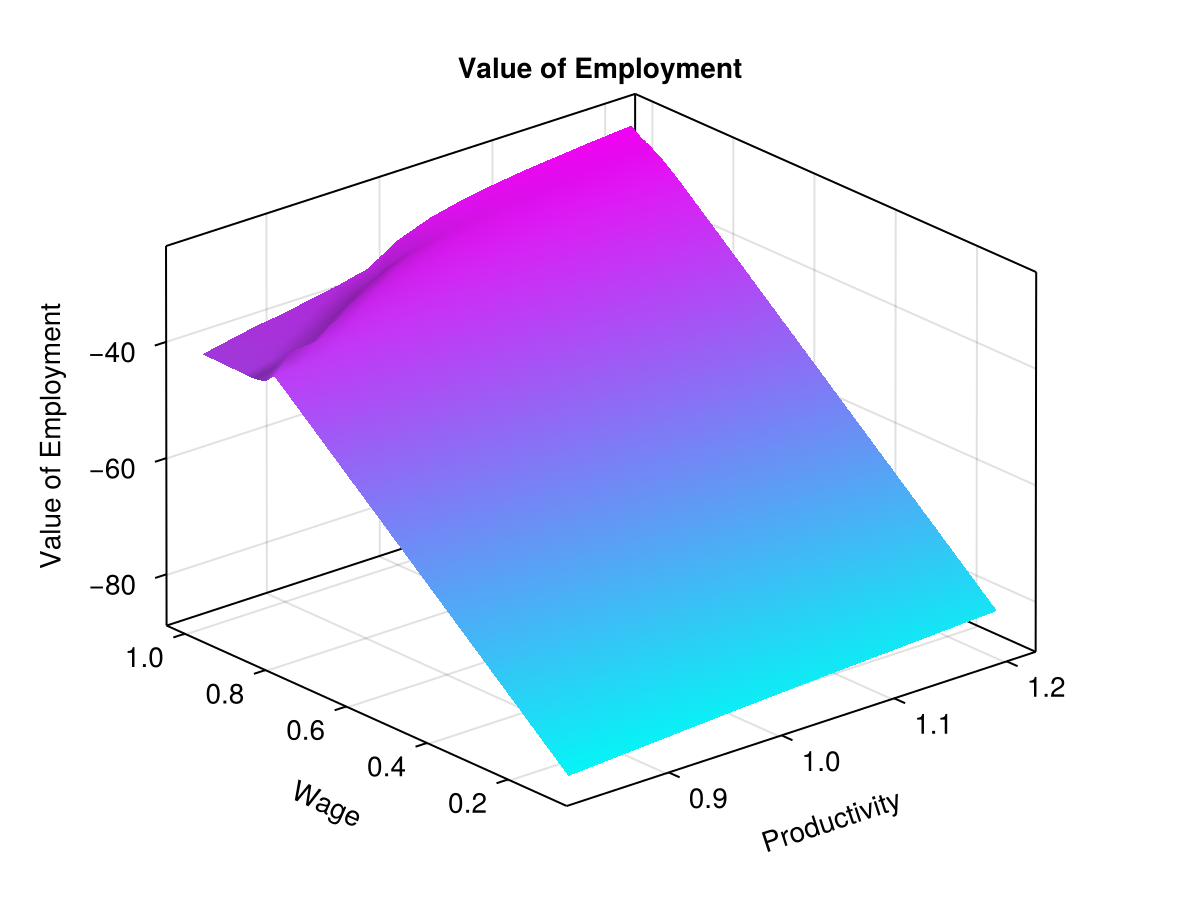

In [42]:
@show W_out

fig_W = Figure()
ax_W = Axis3(fig_W, xlabel = "Productivity", ylabel = "Wage", zlabel = "Value of Employment", title = "Value of Employment")
surface!(ax_W, test_z_grid, test_w_grid, W_out', colormap = :cool)
fig_W[1,1] = ax_W
fig_W

U_out = [-42.79130175261288 -41.84609465722756 -40.89496761997806 -40.283774469373064 -39.32340520926942 -38.423501584497984 -37.39715146038117 -36.51835912733137 -35.60111467093032 -34.72429635947911 -33.90686459004629 -33.029748864610035 -32.126529471435944 -30.80386729267792 -29.76186564580427; -42.773091291509985 -41.82789425898663 -40.877034934404946 -40.26584328151701 -39.30547453782822 -38.40557711933972 -37.37947890449676 -36.500690474523 -35.58344622613812 -34.70662792521974 -33.889196156060144 -33.01208043033299 -32.10886103680154 -30.786198857710534 -29.74419721050321; -42.75488072695033 -41.80969315100356 -40.859095975219574 -40.24772437799067 -39.28754174945784 -38.38765253807846 -37.36180631310743 -36.483021789521395 -35.56577774962623 -34.68895945957243 -33.87152769103106 -32.99441196534304 -32.09119257181431 -30.768530392723505 -29.726528745516198; -42.73657247306494 -41.79149146679563 -40.84115431781394 -40.22952445778777 -39.269607704788214 -38.36972334139717 -37.3439

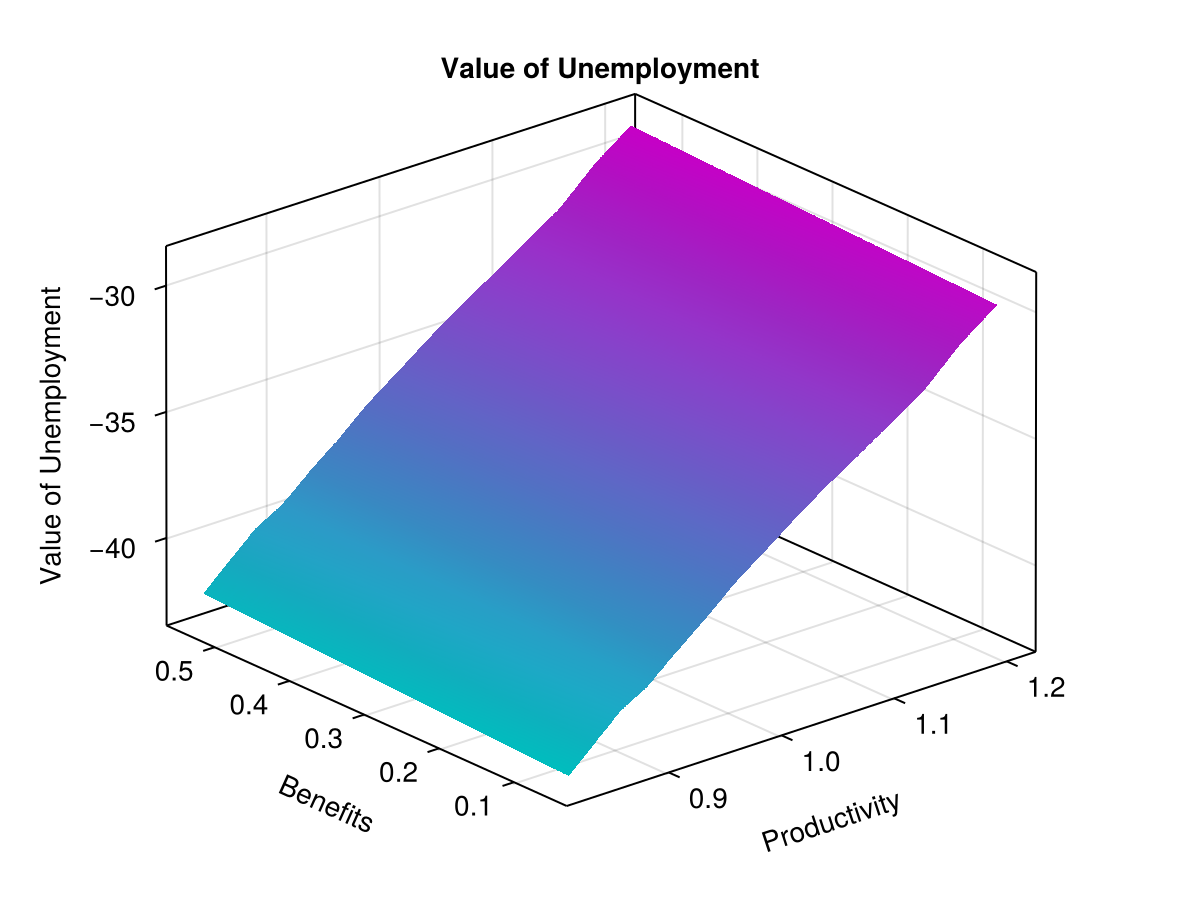

In [43]:
@show U_out

test_b_grid = benefits_grid(pars)

fig_U = Figure()
ax_U = Axis3(fig_U, xlabel = "Productivity", ylabel = "Benefits", zlabel = "Value of Unemployment", title = "Value of Unemployment")
surface!(ax_U, test_z_grid, test_b_grid, U_out', colormap = :cool)
fig_U[1,1] = ax_U
fig_U


s_pol = [0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.36 0.36 0.38 0.36 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.34 0.36 0.38 0.36 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.34 0.36 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.34 0.34 0.36 0.36 0.36 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.34 0.34 0.36 0.36 0.36 0.36 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4; 0.34 0.34 0.36 0.36 0.36 0.36 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4 0.4; 0.34 0.34 0.36 0.34 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4 0.4 0.4 0.4; 0.32 0.34 0.36 0.34 0.36 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4 0.4 0.4; 0.32 0.34 0.34 0.34 0.36 0.36 0.36 0.36 0.38 0.38 0.38 0.4 0.4 0.4 0.4; 0.32 0.32 0.34 0.34 0.34 0.36 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4 0.4; 0.32 0.32 0.34 0.34 0.34 0.34 0.36 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4; 0.32 0.32 0.34 0.34 0.34 0.34 0.36 0.36 0.36 0.38 0.38 0.38 0.38 0.4 0.4; 0.32 0.3

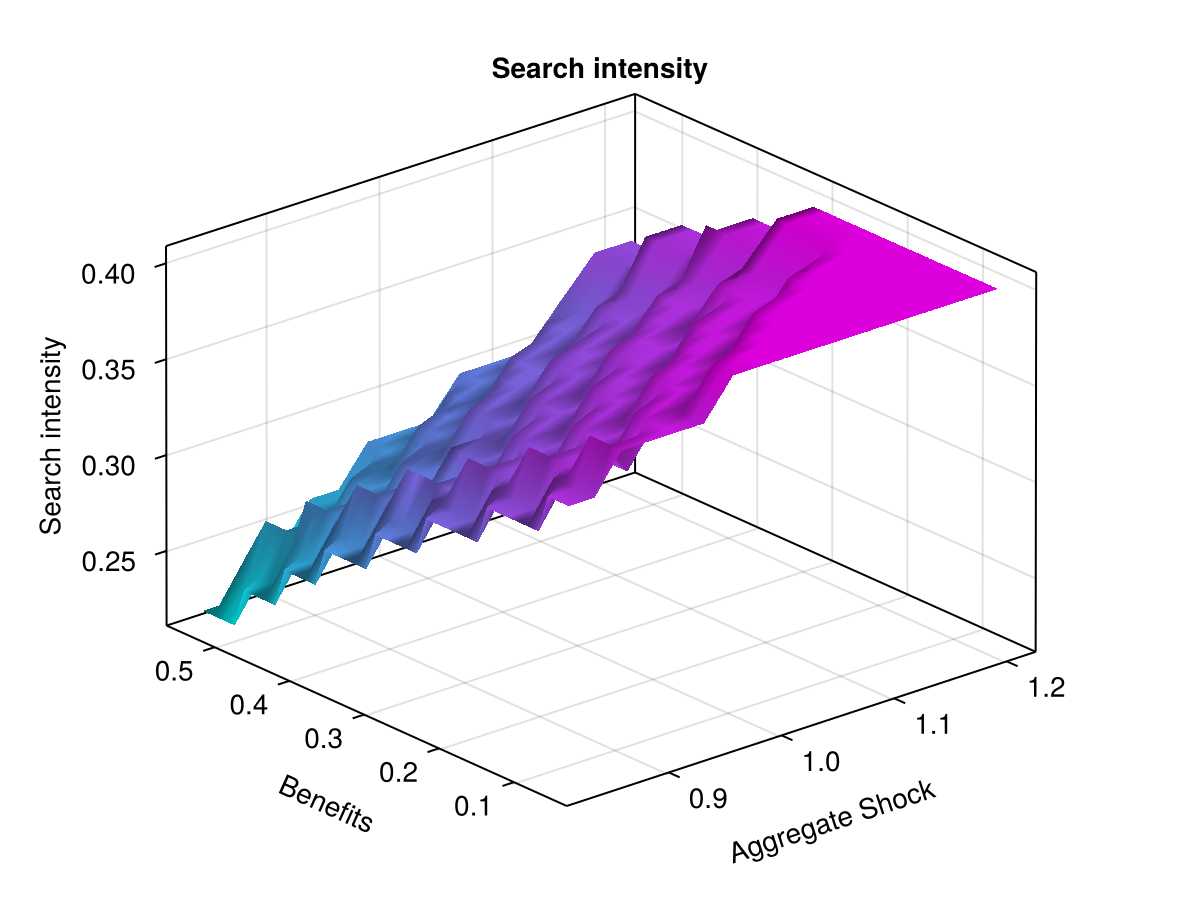

In [21]:
@show s_pol

b_grid_plot = benefits_grid(pars)
z_grid_plot = test_z_grid

fig1 = Figure()
ax1 = Axis3(fig1, xlabel = "Aggregate Shock", ylabel = "Benefits", zlabel = "Search intensity", title = "Search intensity")
surface!(ax1, test_z_grid, b_grid_plot, s_pol', colormap = :cool)
fig1[1, 1] = ax1
fig1

wage_indexes = [0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1.0; 0.825 0.85 0.85 0.85 0.875 0.875 0.9 0.9 0.925 0.925 0.95 0.95 1.0 1.0 1

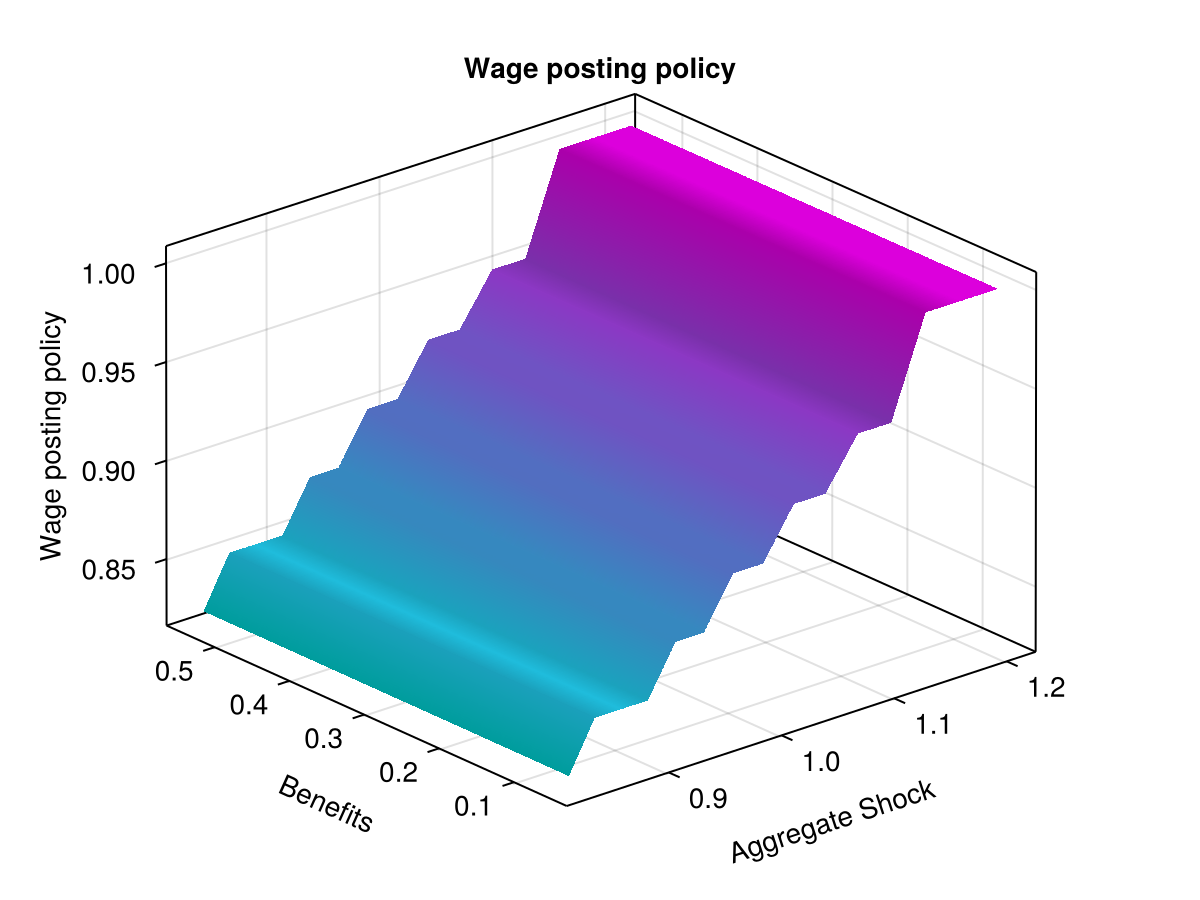

In [22]:
@show wage_indexes

fig2 = Figure()
ax2 = Axis3(fig2, xlabel = "Aggregate Shock", ylabel = "Benefits", zlabel = "Wage posting policy", title = "Wage posting policy")
surface!(ax2, test_z_grid, b_grid_plot, wage_indexes', colormap = :cool)
fig2[1, 1] = ax2
fig2

#### **Simulation**

In [40]:
function sim(pars, search_policy, wage_policy)
    (; Np, T, Tb) = pars
    sim_z_grid, sim_Π = income_process(pars)
    sim_b_grid = benefits_grid(pars)
    sim_w_grid = wage_grid(pars)
    test_θ = thetas(J_out,pars)
    θ_out = θ_probs(test_θ,pars)
    sim_wages_and_benefits = zeros(Np,T)
    sim_emp_status = zeros(Np,T)
    match_p, δ_p, b_p = random_matrices(pars)
    sim_productivity = productivity_sim(pars)

    for i in 1:Np
        for t in 1:T
            prod = findfirst(sim_z_grid .== sim_productivity[i,t])
            if t == 1
                sim_wages_and_benefits[i,t] = sim_b_grid[1]
                sim_emp_status[i,t] = 0
            else
                if sim_emp_status[i,t-1] == 0
                    benefits = findfirst(sim_b_grid .== sim_wages_and_benefits[i,t-1])
                    match_probability = θ_out[benefits, prod]
                    if match_p[i,t] < match_probability
                        sim_emp_status[i,t] = 1
                        sim_wages_and_benefits[i,t] = wage_policy[benefits, prod]
                    else
                        sim_emp_status[i,t] = 0
                        if b_p[i,t] == 1.0
                            sim_wages_and_benefits[i,t] = sim_b_grid[1]
                        else
                            sim_wages_and_benefits[i,t] = sim_wages_and_benefits[i,t-1]
                        end
                        benefits = findfirst(sim_b_grid .== sim_wages_and_benefits[i,t])
                    end
                else
                    if δ_p[i,t] == 1
                        sim_emp_status[i,t] = 0
                        index = findfirst(sim_w_grid .== sim_wages_and_benefits[i,t-1])
                        sim_wages_and_benefits[i,t] = sim_b_grid[index]
                    else
                        if sim_productivity[i,t] < sim_wages_and_benefits[i,t-1]
                            sim_emp_status[i,t] = 0
                            index = findfirst(sim_w_grid .== sim_wages_and_benefits[i,t-1])
                            sim_wages_and_benefits[i,t] = sim_b_grid[index]
                            benefits = findfirst(sim_b_grid .== sim_wages_and_benefits[i,t])
                        else                               
                            sim_emp_status[i,t] = 1
                            sim_wages_and_benefits[i,t] = sim_wages_and_benefits[i,t-1]
                        end
                    end
                end
            end
        end
    end
    sim_wages_and_benefits = sim_wages_and_benefits[:,Tb+1:end]
    sim_emp_status = sim_emp_status[:,Tb+1:end]
    unemployment_rate = (sum(sim_emp_status .== 0) / (Np * (T - Tb))) * 100
    time_series_unemployment = zeros(Tb)
    for t in 1:Tb
        time_series_unemployment[t] = (sum(sim_emp_status[:,t] .== 0) / Np ) * 100
    end

    return sim_wages_and_benefits, sim_emp_status, unemployment_rate, time_series_unemployment
end

sim_out_w, sim_out_e, u_rate, ts_u = sim(pars, s_pol, wage_indexes)
@show u_rate 

u_rate = 5.683975


5.683975

ts_u = [6.1125, 6.275, 6.175, 6.140000000000001, 6.275, 6.1475, 6.12, 6.1975, 6.2725, 6.215, 6.155, 6.1899999999999995, 6.12, 6.077500000000001, 5.9725, 5.81, 5.87, 5.865, 5.8950000000000005, 5.91, 5.8775, 6.04, 6.0249999999999995, 6.08, 6.0125, 5.9624999999999995, 5.96, 5.955, 5.865, 5.9375, 5.935, 5.8500000000000005, 5.885, 5.8625, 5.79, 5.5825, 5.5225, 5.72, 5.675, 5.7250000000000005, 5.680000000000001, 5.53, 5.4375, 5.5525, 5.6000000000000005, 5.66, 5.665, 5.4775, 5.5225, 5.4375, 5.447500000000001, 5.4625, 5.4625, 5.6625000000000005, 5.6775, 5.6025, 5.555000000000001, 5.605, 5.625, 5.575, 5.515, 5.55, 5.6075, 5.617500000000001, 5.5375, 5.545, 5.5675, 5.72, 5.595, 5.64, 5.5925, 5.635, 5.5375, 5.615, 5.6000000000000005, 5.4525, 5.4350000000000005, 5.427499999999999, 5.5325, 5.4775, 5.405, 5.3525, 5.4075, 5.2225, 5.1674999999999995, 5.1425, 5.2475000000000005, 5.3374999999999995, 5.43, 5.395, 5.4175, 5.4525, 5.495, 5.3475, 5.4175, 5.2775, 5.3100000000000005, 5.3025, 5.295, 5.48]


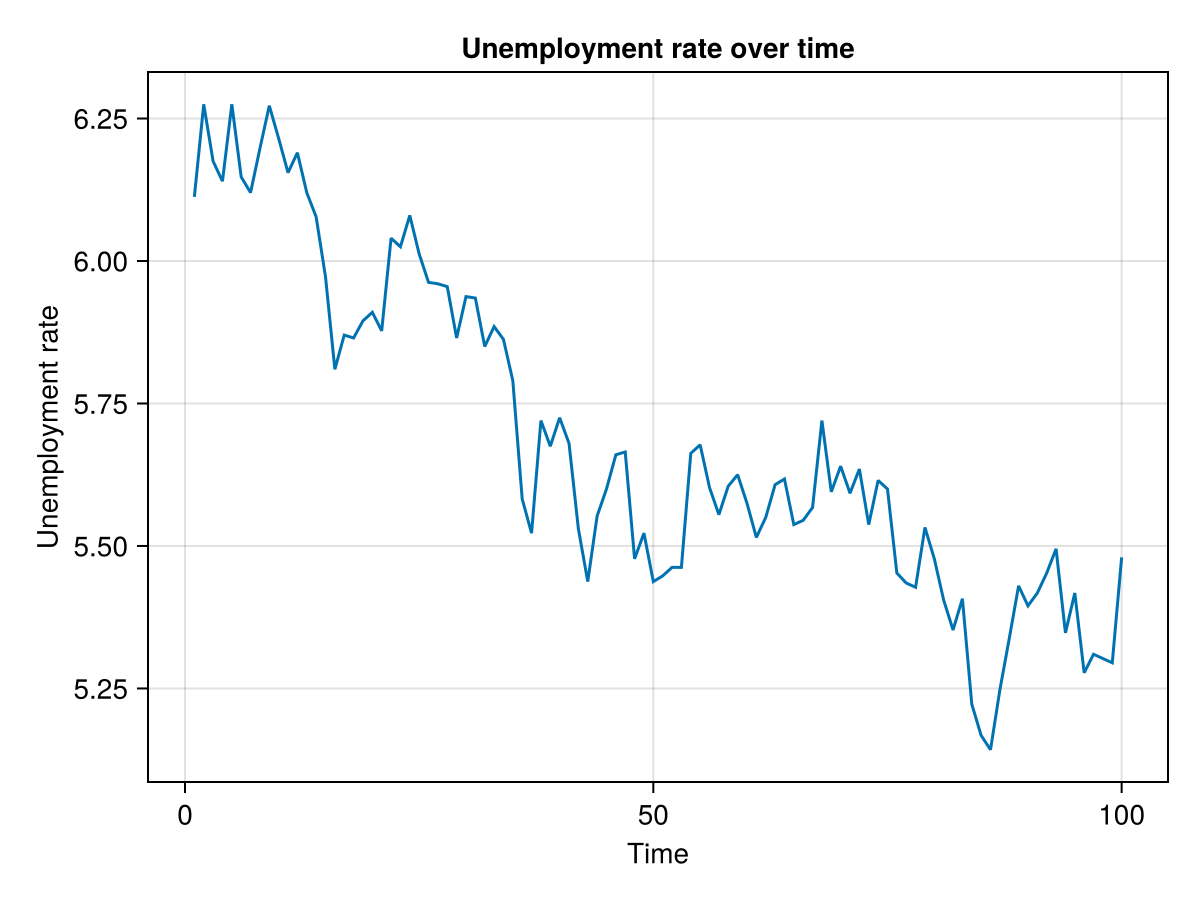

In [41]:
@show ts_u

fig4 = Figure()
ax4 = Axis(fig4, xlabel = "Time", ylabel = "Unemployment rate", title = "Unemployment rate over time")
lines!(ax4, ts_u)
fig4[1,1] = ax4
fig4

In [24]:
function random_matrices(pars)
    (;Np, T, Tb, δ, b_end) = pars
    dist = Uniform(0,1)
    δ_dist = Binomial(1, δ)
    b_dist = Binomial(1, b_end)
    match_probs = rand(dist, Np, T)
    destruction_probs = rand(δ_dist, Np, T)
    end_benefit_probs = rand(b_dist, Np, T)
    return match_probs, destruction_probs, end_benefit_probs
end

test_sim_match, test_sim_δ, test_sim_b = random_matrices(pars)

([0.18963345621478045 0.5810036375204511 … 0.7658004699894749 0.38017655264395367; 0.30676850261237465 0.005131268093683805 … 0.6600896341584903 0.8248940542657965; … ; 0.3252539775662616 0.37610119835125533 … 0.010855133969614905 0.42186799320202506; 0.7836360964186383 0.6364986390095159 … 0.5101870201390848 0.5221552381494635], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 1; … ; 1 0 … 0 0; 0 0 … 0 0])

In [25]:
function productivity_sim(pars)
    (;Np, T, Tb) = pars
    z_grid, Π = income_process(pars)
    prod_sim = zeros(Np,T)
    for i in 1:Np
        prod_sim[i,1] = rand(z_grid)
        for t in 2:T
            state_idx = findfirst(isequal(prod_sim[i,t-1]),z_grid)
            prod_sim[i,t] = z_grid[rand(Categorical(Π[state_idx,:]))]
        end
    end
    return prod_sim
end

test_prod_sim = productivity_sim(pars)

40000×1000 Matrix{Float64}:
 0.851152  0.851152  0.851152  0.874324  …  0.973497  0.973497  0.973497
 0.874324  0.874324  0.874324  0.874324     0.973497  0.973497  0.973497
 1.11343   1.08392   1.08392   1.08392      1.0       1.0       1.0
 0.851152  0.851152  0.874324  0.874324     0.973497  0.973497  0.947696
 0.851152  0.851152  0.851152  0.851152     1.02722   1.0       1.0
 0.828594  0.851152  0.851152  0.851152  …  1.0       1.0       1.0
 1.17488   1.17488   1.17488   1.17488      1.0       1.0       1.02722
 0.898128  0.898128  0.874324  0.874324     1.0       1.0       1.02722
 0.898128  0.898128  0.898128  0.922579     1.0       1.0       1.0
 0.922579  0.922579  0.898128  0.898128     0.973497  0.973497  0.973497
 ⋮                                       ⋱                      
 0.898128  0.898128  0.898128  0.922579     1.0       1.0       1.0
 1.20686   1.20686   1.20686   1.20686      0.973497  0.973497  0.973497
 0.828594  0.828594  0.828594  0.828594     1.11343   1.08